In [61]:
using Pkg
Pkg.activate("../..")
using Plots, ForwardDiff, SymbolicNumericIntegration, SymPy

  Activating project at `~/Documents/STUDY/Bsc/ComplexSystems/blog/JuliaChaos`


## Intro

The generalization of a system is simply illustrated as a set of equations that describe the evolution of the system, which might depend on a set of $m$ equations involving one dimensional differential equations with $n$ variables, which we shall call parameters of the system.

The simplest case ininvolves a one dimentional non-time dependent system (i.e. *autonomus* system) of the form:

$$\dot{x} = f(x)$$

where $x$ is the state of the system and $f(x)$ is a function of the state of the system.

However, the generalization of the system is not limited to this case, but it can be extended to a one dimensional time dependent system (i.e. *nonautonomus* system) with a simple coordinate transform.

As it might became non trivial to solve the system explicitly, we use a straightforward analytical method to study the dynamics of the system based on studying the behavour of the flow in the DE.
 

## Analytical method

The analytical method is based on the following steps:

1. Find the $\dot{x} = f(x)$ function for your problem.
2. Plot the function $f(x)$.
3. Note that the $y$ axis corresponds to speeed, so if $f(x) > 0$ the flow is going to the right, and if $f(x) < 0$ the flow is going to the left. This will allow us to understand the behavour of the flow. To put it in other words, the flow is going to the right if $f(x) > 0$ and to the left if $f(x) < 0$.
4. Note that some points will have $f(x) = 0$, which means that the flow is not moving at all. This is called a **fixed point**.
5. For each point, you can infer, if the flow at the left and the right are converging or diverging. This is called the **stability** of the fixed point. If the flow is converging, the fixed point is called **stable** (namely, **sinks**), and if the flow is diverging, the fixed point is called **unstable** (alsow known as sources).

Note how simple this method is, and how powerful it is. It allows us to understand the behavour of the system without solving the DE explicitly. Lets now tackle a simple example:

---
### Example 1

Consider the following DE:
$$\partial_t x= \cos{(x)}$$

1. Just a toy example. Just write the DE in the form $\dot{x} = \cos{(x)}$.
2. Lets plot the function $f(x) = \cos{(x)}$. This is called the **Trajectory** of the system.

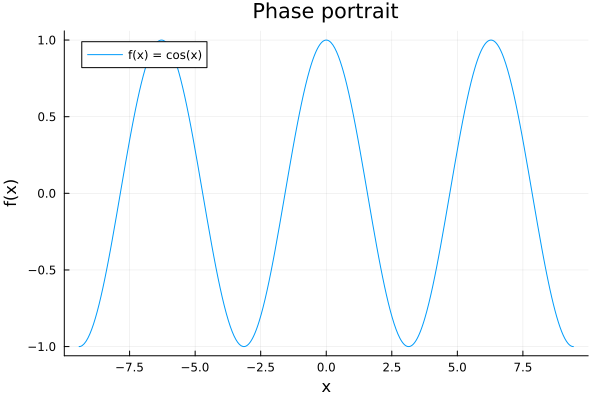

In [62]:
f(x) = cos(x)
plot(f, -3π, 3π, label="f(x) = cos(x)", xlabel="x", ylabel="f(x)", legend=:topleft, title="Phase portrait")

3. Lets now plot the flow of the system... 
 
Remember that if the function is positive, the flow is going to the right, and if the function is negative, the flow is going to the left. So, the flow is going to the right if $\cos{(x)} > 0$ and to the left if $\cos{(x)} < 0$.

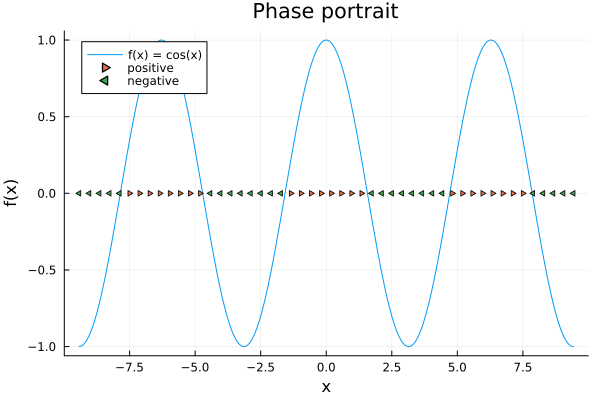

In [63]:
xs = range(-3π, 3π, length=50)
ys = f.(xs)

# Keep only the positive values
positive_mask = ys .> 0
# Plot the positive values
scatter!(xs[positive_mask], ys[positive_mask].*0, label="positive", markershape=:rtriangle)

# Keep only the negative values
negative_mask = .!positive_mask
# Plot the negative values
scatter!(xs[negative_mask], ys[negative_mask].*0, label="negative", markershape=:ltriangle)

4. Plot the fixed points of the flow. We remark that those corresponf to equilibria of the system. In this case, we have infinite of them because the function is periodic.

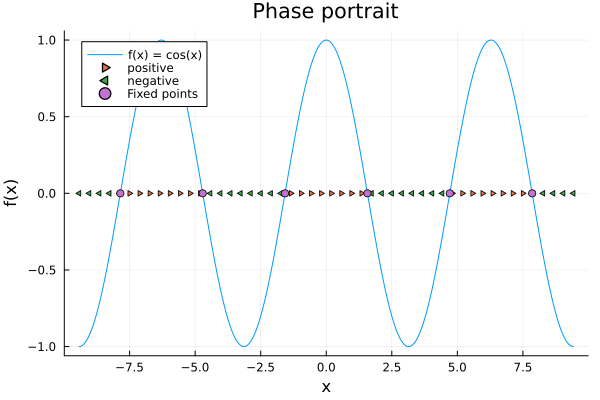

In [64]:
# Scatter the points where the function is zero
interscet = Vector(-3π+0.5π :π:3π-.5π)
scatter!(interscet, f.(interscet), label="Fixed points", markershape=:circle)

5. Classify the fixed points as stable or unstable

In [65]:
function is_stalbe(x::Float64, f::Function; δ=0.1)
    # Check if the left goes up and the right goes to the left
    δ = abs(δ * x + 1e-10)
    if f(x-δ) > f(x) && f(x+δ) < f(x)
        return true
    end
    return false
end

is_stalbe (generic function with 1 method)

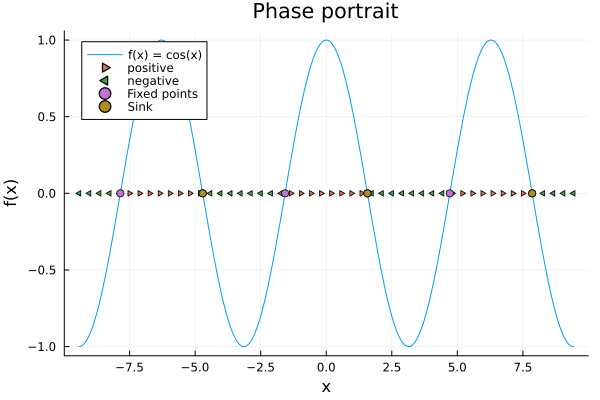

In [66]:
stable = is_stalbe.(interscet, f)
scatter!(interscet[stable], f.(interscet[stable]), label="Sink", markershape=:circle)

Pretty simple, right? Lets now make some simulations to see how the system behaves.

In [67]:
function simulate(x0::Float64, f::Function; n::Int = 100, dt::Float64 = 0.1)
    x = x0
    xs = zeros(n)
    vs = zeros(n)
    for i in 1:n
        x += f(x) * dt
        @inbounds xs[i] = x
        @inbounds vs[i] = f(x)
    end
    return xs, vs
end

simulate (generic function with 1 method)

┌ Info: Saved animation to /home/jose/Documents/STUDY/Bsc/ComplexSystems/blog/JuliaChaos/entries/one_dim_flows/flow.gif
└ @ Plots /home/jose/.julia/packages/Plots/M4dfL/src/animation.jl:156


Plots.AnimatedGif("/home/jose/Documents/STUDY/Bsc/ComplexSystems/blog/JuliaChaos/entries/one_dim_flows/flow.gif")
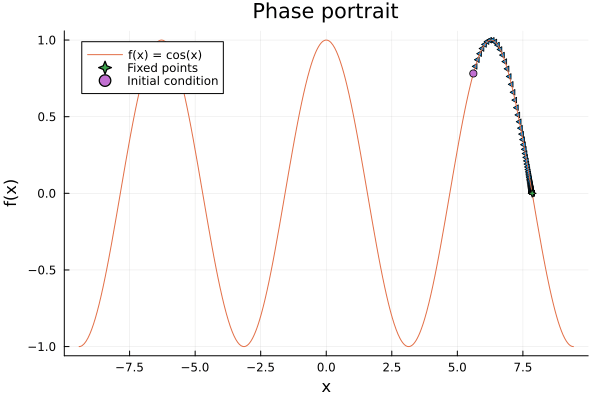

In [68]:
anim = @animate for x0 in rand(Vector(-2π:0.01:3π), 20)
    @fastmath simu_xs, simu_vs = simulate(x0, f)
    if simu_xs[1] > simu_xs[2]
        marks = :rtriangle
    else
        marks = :ltriangle
    end
    for t in eachindex(simu_xs)
        scatter(simu_xs[1:t], simu_vs[1:t], label=false, markershape=marks, xlabel="x", ylabel="f(x)", legend=:topleft, title="Phase portrait")
        plot!(f, -3π, 3π, label="f(x) = cos(x)")
    end
    scatter!([simu_xs[end]], [simu_vs[end]], label="Fixed points", markershape=:star4)
    scatter!([simu_xs[1]], [simu_vs[1]], label="Initial condition", markershape=:circle)
    sleep(0.5)
end
gif(anim, "flow.gif", fps = 1)

Do you notice something interesting in the simulation?
Ofcourse!, It ends up in a fixed point, besides we start from a random initial condition. This is because the system is periodic, and it will always end up in the same fixed point. This is called a **periodic orbit**.

## Linear stability

Besides the method above is very useful to understand the behavour of the system, it is not very useful to understand numerically the behavour of the system. For this, we need to use numerical methods. However, we can use the method above to understand the behavour of the system in the linear regime. This is called ***linearization***.

The idea is to linearize the DE around a fixed point. This is done by using the ***Taylor expansion***. The Taylor expansion is a method to approximate a function around a point. For example, if we want to approximate the function $f(x)$ around the point $x_0$, we can write:

$$f(x) = f(x_0) + f'(x_0)(x-x_0) + \frac{f''(x_0)}{2!}(x-x_0)^2 + \frac{f'''(x_0)}{3!}(x-x_0)^3 + \dots$$

where $f'(x_0)$ is the derivative of the function $f(x)$ at the point $x_0$, $f''(x_0)$ is the second derivative of the function $f(x)$ at the point $x_0$, and so on.

The trick is to neglect all the terms that are not linear in $x-x_0$. (i.e. the terms that are not linear in the perturbation). 

WARNING: It is safe to to neglect the higher order terms if the function is smooth. If the function is not smooth (i.e, you can actually expand it) and if $f'(x_0)$ is not zero, otherwise it would no longer be a leading order approximation.

In this manner, if we can rewrite the DE as:
$$\dot{x} = f(x) = f(x_0) + f'(x_0)(x-x_0),$$

wich corresponds to the classic exponential growth or decay of a perturbation around a fixed point. Another important term arises here: the ***growth rate***. The growth rate is the rate at which the perturbation grows or decays. In this case, the growth rate is given by $f'(x_0)$.

The rate allow to define a ***characteristic time scale*** of the system at $x_0$, which is the time it takes for the perturbation to grow or decay by a factor of $e$. In this case, the characteristic time is given by $1/|f'(x_0)|$.

The stability at fixed points with inflexion points is not generalizable to the linear regime, see for instance the expample at these three examples:


In [69]:
"""
analytic_solve: Analitically solve any one dimensional flow system
"""
function analytic_solve(f::Function, xs::AbstractArray; n::Int = 1000, δ::Float64=0.00001)
    # Plot the 
    ys = f.(xs)
    plot(xs, ys, label="f(x)")
    # Plot the fixed points
    positive_mask = ys .> 0
    # Plot the positive values
    scatter!(xs[positive_mask], ys[positive_mask].*0, label="positive", markershape=:rtriangle)
    # Keep only the negative values
    negative_mask = .!positive_mask
    # Plot the negative values
    scatter!(xs[negative_mask], ys[negative_mask].*0, label="negative", markershape=:ltriangle)
    # Scatter the points where the function is zero
    closer_to_zero = abs.(f.(range(minimum(xs), maximum(xs), n))) .< δ
    interscet = range(minimum(xs), maximum(xs), n)[closer_to_zero]
    scatter!(interscet, f.(interscet), label="Fixed points", markershape=:circle)
    # Check if the fixed points are stable
    stable = is_stalbe.(interscet, f)
    scatter!(interscet[stable], f.(interscet[stable]), label="Sink", markershape=:circle)
end

analytic_solve

1. $$\dot{x} = x^2$$

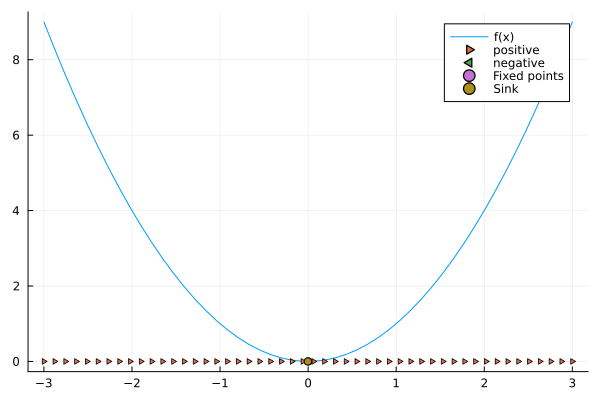

In [70]:
# Plot the function
xs = range(-3, 3, length=50)
f_1 = x -> x^2
analytic_solve(f_1, xs)

Do you see the problem? The function is not smooth, so we cannot expand it. And, when solving analytically, we see that it is a strange attractor from the left, and a repeller from the right. We call this a **half-stable**.

This is not general for all non-linearizable cases, as well see in the next two examples.

2. $$\dot{x} = x^3$$

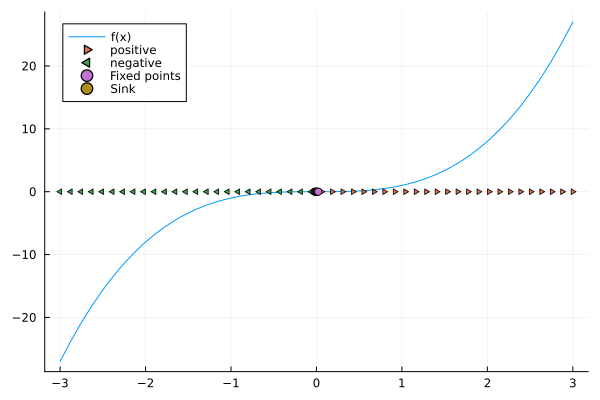

In [71]:
f_2 = x -> x^3
analytic_solve(f_2, xs)

3. $$\dot{x} = -x^3$$

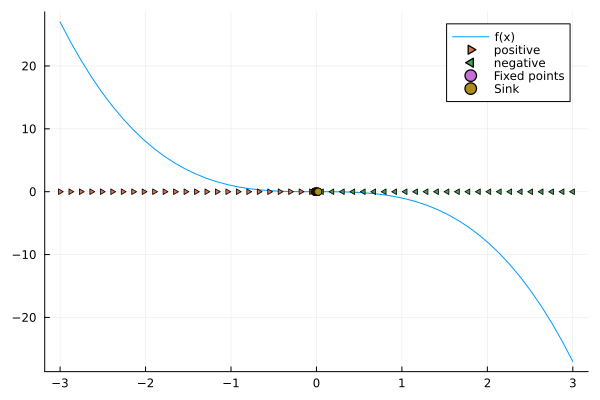

In [72]:
f_3 = x -> -x^3
analytic_solve(f_3, xs)

## Uniquness

You might have noticed that we stated the `analytic_solve` as a universal solver... But it was a complete lie! The analytic solver works as expected if a solution is unique, which is given by the ***uniqueness theorem***. The uniqueness theorem states that if the DE is autonomous, and if the DE has a unique solution, consider:

$$\dot{x} = f(x); x(0) = x_0$$

Then, the solution is unique and has solution in a interval $[x_0 - \delta x, x_0 + \delta x]$ if and only if the functions $f(x)$ and $f'(x)$ are continuous in a open interval $\{x\} \in \mathbb{R}$

## Imposibility of occilations

Note that for a first order non-autonomus system, the system can either converge to a fixed point, or diverge to infinity. And it is very straight forward to see why, in the plots $y=f(x)$ and $y=\dot{x}$, the function (obviosly) is singled valued, so it can no pass through the same point twice. This is called the ***imposibility of occilations***.

## From Flows to Potentials

In physics, we are more used to study systems in terms of **potentials**. The idea is to rewrite the DE in terms a poential $V(x)$, which is a function that describes the energy of the system. The DE is then rewritten as:

$$\dot{x} = -\frac{\partial V(x)}{\partial x} \ \ \Rightarrow \ \ \frac{d x}{d t}= -\frac{\partial V(x)}{\partial x} $$

$$V(x) = \int_{x_0}^x \dot{x} \ dx $$

Note that the minus arisesnaturally to make the stable fixed points have a minimum of the potential, and the unstable fixed points have a maximum of the potential, but for both of them, equilibriums of the system. Notice also that $V(t)$ is monotonically decresing along trajectories.


---
### Example:

Graph the potential of $\dot{x} = x - x^3$, identify the fixed points and classify them as stable or unstable.



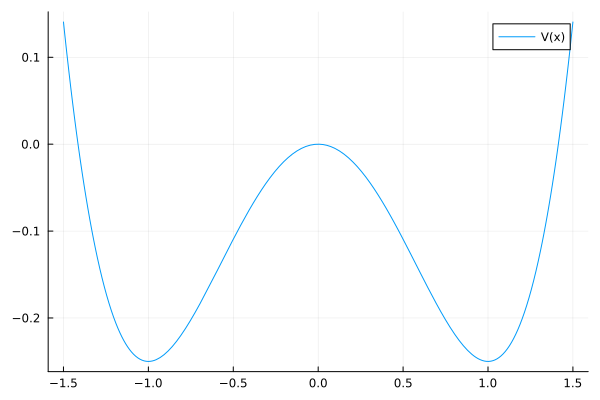

In [73]:
f_4(x) = x - x^3
@SymPy.syms x
V = SymPy.integrate(f_4(x), x)
plot(-V, -1.5, 1.5, label="V(x)")

Clearly, we have three fixed points: $x=0$, $x=1$, and $x=-1$, there is only one local maximum (corresponding to the source) at $x=0$, and two local minimums (corresponding to the sinks) at $x=1$ and $x=-1$. This potential is called a **double-well potential**, and it is of special interest in particle physics, as it represents the Higgs potential.

Now, let's use our analytic method to verify the results.


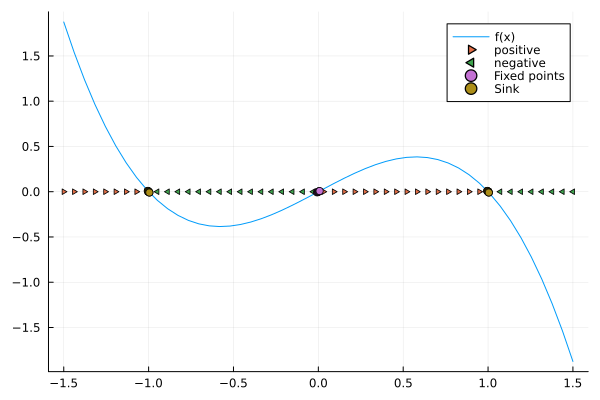

In [74]:
xs = range(-1.5, 1.5, length=50)
analytic_solve(f_4, xs; δ =0.01)

## Summary

In this post, we have seen how to solve first order DEs, and how to use the analytic method to understand the behavour of the system. We have also seen how to linearize the DE around a fixed point, and how to use the growth rate to define a characteristic time scale of the system. Finally, we have seen how to rewrite the DE in terms of a potential, and how to identify the fixed points and classify them as stable or unstable. 

Here are the main concepts:

 * **Vector Field**: A vector field is a function that maps a point in space to a vector. In the case of DEs, the vector field is the function $f(x)$,  the plot corresponds to the phase portrait.
 * **Fixed Point**: A fixed point is a point in space where the vector field is zero, corresponding to a equilibrium of the system.
 * **Stability**: A fixed point is stable if the vector field points away from it, and unstable if the vector field points towards it.
 * **Global Stability**: A fixed point is globally stable if all trajectories converge to it, and globally unstable if all trajectories diverge from it.
 * **Linearization**: A linearization is a first order approximation of a function around a point. In the case of DEs, the linearization is a first order approximation of the vector field around a fixed point.
 * **Characteristic Time Scale**: The characteristic time scale is the time it takes for a perturbation to grow or decay by a factor of $e$. It is given by $1/|f'(x_0)|$ where $x_0$ is a fixed point.
 * **Potential**: A potential is a function that describes the energy of the system. It is given by $V(x) = \int_{x_0}^x \dot{x} \ dx$ where $x_0$ is a fixed point.

Hope you enjoyed it! See you in the next post!